**Table of contents**<a id='toc0_'></a>    
- [Understand what these features are about](#toc1_1_)    
  - [Try baseline model without the surface features](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [42]:
import pandas as pd
from dfply import mask, X
import plotly.express as px

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
df = pd.read_csv("../data/raw/train.csv")

In [3]:
top_10 = ['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'YearBuilt',
 'BsmtFinSF1',
 'GarageFinish_Unf',
 'OverallCond',
 '1stFlrSF',
 'CentralAir']

## <a id='toc1_1_'></a>[Understand what these features are about](#toc0_)

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [4]:
df.OverallQual.value_counts(dropna=False) # no null values and it seems this is a pretty good rating system. keep.

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64

GrLivArea: Above grade (ground) living area square feet
TotalBsmtSF: Total square feet of basement area
BsmtFinSF1: Type 1 finished square feet
1stFlrSF: First Floor square feet

Thoughts:
- BsmtFinSF1 is related to the TotalBsmtSF. I would just keep the first one.
- There is very minute separation of the different living areas, which is probably excessive. Also, the 1stFlrSF will definitely be correlated with the GrLivArea if there is a first floor, so these features will give about the same information. They could also be correlated to the TotalBsmtSF, if there is a basement.

Further steps:
- I'd perhaps create binary features for 1st floor & basement, keep GrLivArea as the main area feature.

In [5]:
df.BsmtCond.value_counts(dropna=False) # only 37 houses don't have a basement! might become an irrelevant feature.

BsmtCond
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: count, dtype: int64

In [6]:
df['basement'] = df['BsmtCond'].isna()

In [7]:
(df['1stFlrSF'] > 0.0).value_counts() # ALL HOUSES HAVE A FIRST FLOOR????

1stFlrSF
True    1460
Name: count, dtype: int64

<Axes: >

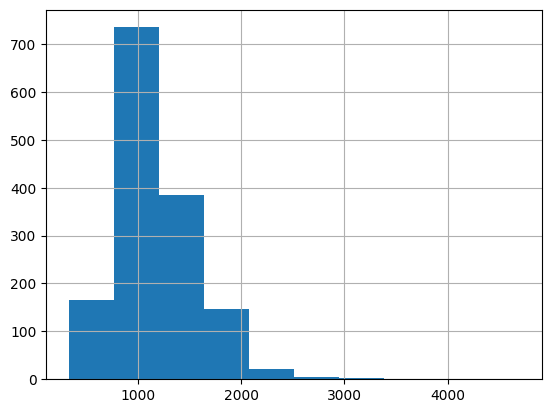

In [8]:
df['1stFlrSF'].hist()

In [9]:
px.scatter(df, x='GrLivArea', y='1stFlrSF').update_layout(width=600, height=600)

Clear linear correlation. Kept the chart square because these 2 variables have the same units.

In [10]:
px.scatter(df, x='GrLivArea', y='TotalBsmtSF').update_layout(width=600, height=600)

In [11]:
px.scatter(df, x='BsmtFinSF1', y='TotalBsmtSF').update_layout(width=600, height=600)

Hypotheses confirmed for the other things, too :)

I wanna see how the model does without all of these living areas. Will do that after reviewing the rest of the features.

GarageCars: Size of garage in car capacity

I'd say a garage is not necessarily related to the size of the house as it's usually an appendix to the house.

In [12]:
px.box(df, x='GrLivArea', color='GarageCars', category_orders={'color': sorted(list(df.GarageCars.astype(int).unique()))})

Having a greater living area doesn't necessarily correlate with a garage space suitable for more cars, so we keep this one.

YearBuilt: Original construction date

There is also a year remodel date but I imagine that would be correlated with the Overall Quality of the house, whereas YearBuilt would be more about the architecture of the house.

In [13]:
df.YearBuilt.isna().mean()

0.0

<Axes: >

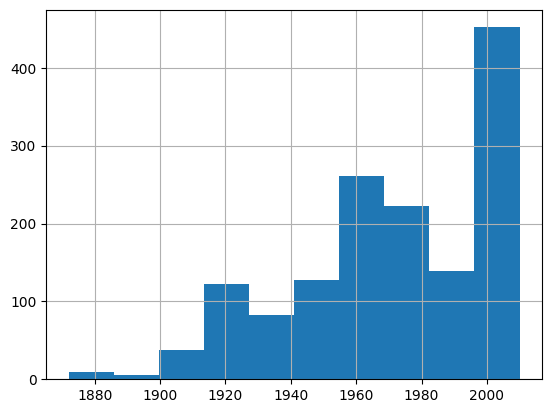

In [14]:
df.YearBuilt.hist()

In [15]:
px.scatter(df, x='YearBuilt', y='SalePrice')

Small positive correlation - interesting that it's in the top 10 features.

OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

In [16]:
df.OverallCond.value_counts(dropna=False)

OverallCond
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: count, dtype: int64

In [17]:
px.density_heatmap(df, x='OverallCond', y='OverallQual')

CentralAir

In [18]:
df.CentralAir.value_counts(dropna=False) # only affects 95 houses, why is it so important?

CentralAir
Y    1365
N      95
Name: count, dtype: int64

In [19]:
px.box(df, y='SalePrice', color='CentralAir')

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [20]:
df.GarageFinish.value_counts(dropna=False)

GarageFinish
Unf    605
RFn    422
Fin    352
NaN     81
Name: count, dtype: int64

In [21]:
px.box(df, y='SalePrice', color='GarageFinish')

Why is this so relevant? (Disbelief)

## <a id='toc1_2_'></a>[Try baseline model without the surface features](#toc0_)

In [22]:
from pycaret.regression import *

In [37]:
df['GarageFinish_Unf'] = (df['GarageFinish'] == 'Unf').astype(int)

In [38]:
top = ['OverallQual',
 'GrLivArea',
 'GarageCars',
 'YearBuilt',
 'GarageFinish_Unf',
 'CentralAir']

In [39]:
experiment = setup(data=df[top + ['SalePrice']], target='SalePrice', session_id=123, transform_target=True, keep_features=top) 

,Description,Value
0,Session id,123
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 7)"
4,Transformed data shape,"(1460, 7)"
5,Transformed train set shape,"(1021, 7)"
6,Transformed test set shape,"(439, 7)"
7,Numeric features,5
8,Categorical features,1
9,Keep features,6


In [40]:
model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,21856.2665,1053241460.5849,32045.7909,0.8361,0.1686,0.1268,0.0650
lightgbm,Light Gradient Boosting Machine,23398.0744,1296322185.7039,35504.0616,0.8032,0.1769,0.1350,0.1320
et,Extra Trees Regressor,23842.2545,1398238017.7648,36395.9749,0.7884,0.1844,0.1379,0.0950
rf,Random Forest Regressor,23758.9929,1485756695.0479,37492.8474,0.7789,0.1826,0.1369,0.1370
ada,AdaBoost Regressor,27642.9929,1608540765.6665,39646.4655,0.7544,0.2063,0.1602,0.0590
lr,Linear Regression,23361.4618,2147555674.3278,41542.3598,0.6802,0.1810,0.1360,1.0990
lar,Least Angle Regression,23361.4618,2147555674.3277,41542.3598,0.6802,0.1810,0.1360,0.0260
ridge,Ridge Regression,23359.1289,2151443389.4932,41561.3274,0.6797,0.1810,0.1360,0.0370
br,Bayesian Ridge,23356.4453,2160332888.1161,41606.9538,0.6784,0.1810,0.1360,0.0280
dt,Decision Tree Regressor,31450.1888,2429167204.1434,48242.6507,0.6239,0.2478,0.1837,0.0270


In [41]:
px.histogram(x=model.feature_importances_, y=model.feature_names_in_).update_yaxes(categoryorder='total ascending')

We still keep an R2 score of 0.83 even when we have just 6 features. Also, the performance for the regression models was significantly improved, which suggests that there is some linear relationship between the features chosen and the sale price, even if it was hidden in the previous model iteration.

Are we done with the features tho? I think we can get more information from this dataset, but let's see how good our submission is :).

In [31]:
test_df = pd.read_csv("../data/raw/test.csv")
predictions = predict_model(estimator=model, data=test_df)[['Id', 'prediction_label']].rename({'prediction_label': 'SalePrice'}, axis=1)
predictions.to_csv("../models/submissions/submission1.csv", index=False)

Yay! I get a score of 0.16901 with minimal features & feature engineering! But still didn't beat my students :-?

## What predictions do I get wrong the most?

In [32]:
train_pred = predict_model(estimator=model, data=df)
px.scatter(x='prediction_label', y='SalePrice', data_frame=train_pred).update_layout(width=600, height=600)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,18568.0953,703109564.1856,26516.2132,0.8885,0.1412,0.1064


In [34]:
train_pred['error'] = (train_pred['SalePrice'] - train_pred['prediction_label'])
px.histogram(x='error', data_frame=train_pred).update_layout(width=600, height=400)

I perform equally well across all price categories... so where is the issue?

## Check worst predictions

In [49]:
big_errors = train_pred >> mask(X.error.abs() > 50000)
big_errors.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,basement,SalePrice,prediction_label,error
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,False,250000,310426.435421,-60426.435421
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,False,307000,240035.983723,66964.016277
13,14,20,RL,91.0,10652,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,Stone,306.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1494,1494,GasA,Ex,Y,SBrkr,1494,0,0,1494,0,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,3,840,TA,TA,Y,160,33,0,0,0,0,NaN,NaN,NaN,0,8,2007,New,Partial,False,279500,210274.544101,69225.455899
56,57,160,FV,24.0,2645,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,8,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,456.0,Gd,TA,PConc,Gd,TA,No,GLQ,649,Unf,0,321,970,GasA,Ex,Y,SBrkr,983,756,0,1739,1,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,1999.0,Fin,2,480,TA,TA,Y,115,0,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Abnorml,False,172500,226485.401916,-53985.401916
66,67,20,RL,NaN,19900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosA,Norm,1Fam,1Story,7,5,1970,1989,Gable,CompShg,Plywood,Plywood,BrkFace,287.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,912,Unf,0,1035,1947,GasA,TA,Y,SBrkr,2207,0,0,2207,1,0,2,0,3,1,TA,7,Min1,1,Gd,Attchd,1970.0,RFn,2,576,TA,TA,Y,301,0,0,0,0,0,NaN,NaN,NaN,0,7,2010,WD,Normal,False,180000,241024.739821,-61024.739821


In [51]:
import plotly.graph_objects as go

In [53]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

for col in df.columns:
    fig = make_subplots(rows=1, cols=2, subplot_titles=("All Data", "Big Errors"), shared_yaxes=False)
    
    fig.add_trace(go.Histogram(x=df[col], name="All Data", opacity=0.75), row=1, col=1)
    fig.add_trace(go.Histogram(x=big_errors[col], name="Big Errors", opacity=0.75), row=1, col=2)
    
    fig.update_layout(
        title_text=f"Side-by-side Histogram of '{col}' (All Data vs Big Errors)",
        width=1000,
        height=400,
        showlegend=False
    )
    fig.update_xaxes(title_text=col, row=1, col=1)
    fig.update_xaxes(title_text=col, row=1, col=2)
    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Count", row=1, col=2)
    fig.show()

KeyError: 'GarageFinish_Unf'

I am mainly looking for distributions that are different compared to the original distribution, such as:
pavement (alley), lotshape, RoofStyle, ExterQual

In [54]:
top = ['OverallQual',
 'GrLivArea',
 'GarageCars',
 'YearBuilt',
 'GarageFinish_Unf',
 'CentralAir',
 'Alley',
 'RoofStyle',
 'LotShape',
 'ExterQual',]

In [55]:
experiment = setup(data=df[top + ['SalePrice']], target='SalePrice', session_id=123, transform_target=True, keep_features=top) 

,Description,Value
0,Session id,123
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 11)"
4,Transformed data shape,"(1460, 22)"
5,Transformed train set shape,"(1021, 22)"
6,Transformed test set shape,"(439, 22)"
7,Numeric features,5
8,Categorical features,5
9,Keep features,10


In [56]:
model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,22030.7396,1232115047.2107,34091.4307,0.8165,0.1691,0.1270,0.0780
lightgbm,Light Gradient Boosting Machine,23329.4419,1402501951.8738,36738.5389,0.7913,0.1763,0.1326,0.1620
rf,Random Forest Regressor,23462.6480,1556779196.9803,38151.5040,0.7725,0.1792,0.1339,0.1660
et,Extra Trees Regressor,24539.7522,1744184103.6496,40557.3408,0.7424,0.1868,0.1383,0.1430
ada,AdaBoost Regressor,27840.6738,1698765079.6662,40672.6381,0.7419,0.2073,0.1602,0.0750
br,Bayesian Ridge,23126.9478,2284917466.3344,41886.6843,0.6625,0.1792,0.1347,0.0400
ridge,Ridge Regression,23225.1337,2315723893.9680,42047.3438,0.6581,0.1797,0.1354,0.0420
lr,Linear Regression,23264.2231,2332938316.7171,42150.3063,0.6557,0.1801,0.1356,0.8430
dt,Decision Tree Regressor,30869.4098,2442957927.6222,48345.7479,0.6298,0.2410,0.1791,0.0390
knn,K Neighbors Regressor,32606.3383,2629529743.6880,50503.2683,0.6053,0.2336,0.1812,0.0520


In [57]:
px.histogram(x=model.feature_importances_, y=model.feature_names_in_).update_yaxes(categoryorder='total ascending')

Poor strategy, performance decreases. Back to the drawing board.

## What if I don't remove null values?